# <a name="0.0"></a>Содержание:
* [Описание проекта](#0.)
    - [Описание данных](#0.1.)
* [Шаг 1. Подготавливаем данные](#1.)
    - [Открываем файлы и изучаем их](#1.1.)
    - [Вычисляем эффективность обогащения](#1.2.)
    - [Определяем каких признаков нет в тестовой выборке но которые есть в обучающей](#1.3.)
    - [Вывод](#1.4.)
* [Шаг 2. Анализируем данные](#2.)
    - [Анализируем изменение концентрации металлов на различных этапах очистки](#2.1.)
    - [Сравниваем распределения размеров гранул сырья на обучающей и тестовой выборках](#2.2.)
    - [Исследуем суммарную концентрацию всех веществ на разных стадиях](#2.3.)
    - [Вывод](#2.4.)
* [Шаг 3. Строим модель](#3.)
    - [Функция для вычисления sMAPE](#3.1.)
    - [Статическая модель с прогнозированием по медиане](#3.2.)
    - [Статическая модель с прогнозированием по среднему](#3.3.)
    - [Статическая модель с прогнозированием по предыдущим значениям](#3.4.)
    - [Обучение моделей с использованием кросс-валидации](#3.5.)
    - [Вывод](#3.3.)
* [Шаг 4. Общие выводы](#4.)

<a name="0."></a>
## Описание проекта

Необходимо смоделировать процесс восстановления золота из золотосодержащей руды, который имеет следующий вид.

После первичной обрабтки золотоносной руды, получается дроблённая смесь, которую отправляют на флотацию (обогащение) и двухэтапную очистку:

- Флотация: является первой ступенью технологического процесса и позволяет обогатить руду. На выходе флотационной установки получается черновой концентрат и "отвальные хвосты" (остатки продукта с низкой концентрацией ценных металлов). Стабильность данного процесс зависит от непостоянного физико-химического состояния флотационной пульпы (жидкость с твёрдыми частицами)
- Очистка (двухстадийная): на выходе получается концентрат и новые отвальные хвосты

![Процесс](process.jpg "Процесс обогощения")

Эффективность обогащения рассчитывается по формуле:<br>
$Recovery = \frac{ C \times (F-T)}{F \times (C - T)}$<br>
где:<br>
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для нахождения коэффициента нужно найти долю золота в концентратах и хвостах

В данной задаче используется метрика качества sMAPE (Symmetric Mean Absolute Percentage Error), которое похоже на MAE, но выражается не в абсолютных величинах, а в относительных, и позволяет учитывать масштаб целевого признака и предсказания:
$sMAPE = \frac{1}{N}\sum \frac{|y_i-\widehat{y_i}|}{(|y_i|+|\widehat{y_i}|)/2}\times100%%$<br>

Итоговая метрика скадывается из 2 величин:<br>
$sMAPE_{итоговая} = 0.25 \times sMAPE_{rougher} + 0.75 \times sMAPE_{final}$

<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="0.1."></a>
### Описание данных:

Наименование признаков имеет следующий формат:<br>
>**[этап].[тип_параметра].[название_параметра]**

где [этап] может принимать следующие значения:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

где [тип_параметра] может принимать:
- input — параметры сырья
- output - параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

где [название_параметра] может формировать или для описания технологического процесса
- rougher feed — исходное сырье
- rougher additions (или reagent additions) — флотационные реагенты
    - Xanthate — ксантогенат (промотер, или активатор флотации)
    - Sulphate — сульфат (на данном производстве сульфид натрия)
    - Depressant — депрессант (силикат натрия)
- Rougher process (грубый процесс) — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

или для описания параметров этапа:
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

Прогнозируемые величины:
- rougher.output.recovery - эффективность обогащения чернового концентрата
- final.output.recovery - эффективность обогащения финального концентрата
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="1."></a>
# Шаг 1. Подготавливаем данные
<font size="2">([к содержанию](#0.0))</font> 

<a name="1.1."></a>
## Открываем файлы и изучаем их
<font size="2">([к содержанию](#0.0))</font> 

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = None

In [2]:
train_data = pd.read_csv('./datasets/gold_recovery_train.csv',
                         index_col='date',
                         parse_dates=True)
test_data = pd.read_csv('./datasets/gold_recovery_test.csv',
                        index_col='date',
                        parse_dates=True)
data = pd.read_csv('./datasets/gold_recovery_full.csv',
                   index_col='date',
                   parse_dates=True)

In [3]:
train_data.head(5)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [4]:
for name in train_data.columns:
    print(name)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.input.sulfate
primary_cleaner.input.depressant
primary_cleaner.input.feed_size
primary_cleaner.input.xanthate
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
primary_cleaner.state.floatbank8_a_air
primary_cleaner.state.floatbank8_a_level
primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_d_air
primary_cleaner.state.floatbank8_d_level
rougher.calculation.sulfate_to_au_concentrate
rougher.ca

In [5]:
train_data.info()
test_data.info()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

<a name="1.2."></a>
## Вычисляем эффективность обогащения
<font size="2">([к содержанию](#0.0))</font> 

In [6]:
# Выбросим лишнее
train_data = train_data[train_data['rougher.input.feed_au']!=0]
test_data = test_data[test_data['rougher.input.feed_au']!=0]
data = data[data['rougher.input.feed_au']!=0]

In [7]:
C = train_data['rougher.output.concentrate_au']
F = train_data['rougher.input.feed_au']
T = train_data['rougher.output.tail_au']
train_data['rougher.output.recovery_calculated'] = ((C * (F - T)) /
                                                    (F * (C - T))) * 100

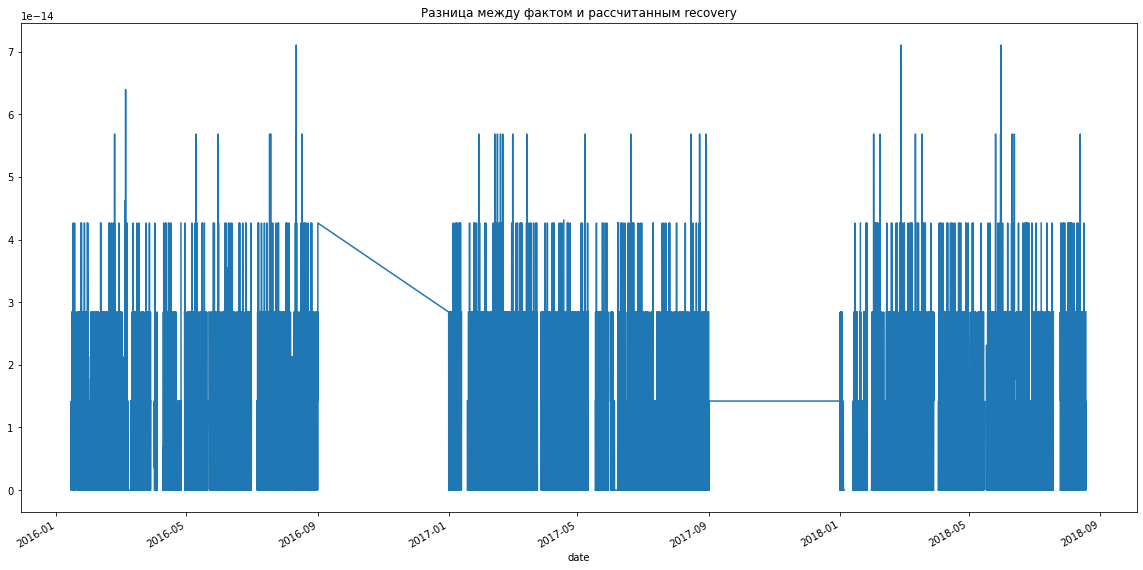

MAE: 9.444891926100695e-15


In [8]:
delta = abs(train_data['rougher.output.recovery'] -
            train_data['rougher.output.recovery_calculated'])
delta.plot(figsize=(20,10))
plt.title('Разница между фактом и рассчитанным recovery')
plt.show()
print('MAE:',delta.mean())

In [9]:
crude_clean = train_data.dropna().shape[0]
crude_clean_p = (train_data.shape[0] - crude_clean) / train_data.shape[0]
print("Было отброшено {} записи или {:.2%} от исходных данных".format(crude_clean, crude_clean_p))

Было отброшено 11017 записи или 29.83% от исходных данных


In [10]:
# Заполняем пропуски предыдущими значениями
train_data.fillna(method='ffill', inplace=True)
data.fillna(method='ffill', inplace=True)
test_data.fillna(method='ffill', inplace=True)

In [11]:
#После заполнения появилось несколько аномальных значений, выбросим их как ненужные
train_data = train_data[((train_data['rougher.output.recovery'] -
                          train_data['rougher.output.recovery_calculated']) < 1) &
                        ((train_data['rougher.output.recovery'] -
                          train_data['rougher.output.recovery_calculated']) > -1)]

In [12]:
#Найдите новую MAE для заполненных данных между вашими расчётами и значением признака.
mean_absolute_error(train_data['rougher.output.recovery'],
                    train_data['rougher.output.recovery_calculated'])

9.48807414104092e-15

<a name="1.3."></a>
## Определяем каких признаков нет в тестовой выборке но которые есть в обучающей
<font size="2">([к содержанию](#0.0))</font> 

In [13]:
for column in train_data:
    if column in test_data.columns:
        print(column)

primary_cleaner.input.sulfate
primary_cleaner.input.depressant
primary_cleaner.input.feed_size
primary_cleaner.input.xanthate
primary_cleaner.state.floatbank8_a_air
primary_cleaner.state.floatbank8_a_level
primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_d_air
primary_cleaner.state.floatbank8_d_level
rougher.input.feed_ag
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.feed_au
rougher.input.floatbank10_sulfate
rougher.input.floatbank10_xanthate
rougher.input.floatbank11_sulfate
rougher.input.floatbank11_xanthate
rougher.state.floatbank10_a_air
rougher.state.floatbank10_a_level
rougher.state.floatbank10_b_air
rougher.state.floatbank10_b_level
rougher.state.floatbank10_c_air
rougher.state.floatbank10_c_level
rougher.state.floatbank10_d_air
rougher.state.floatbank10_d_level
rougher.state.f

<a name="1.4."></a>
## Вывод:

Исходные данные для обучения представлены таблицей размера 16860x86, в которых обнаружено множество пустых значений. Отбрасывать строки с пустыми значениями нельзя, так как при таким подходе теряется слишком много записей (примерно 1/3 от всех значений). Так как соседние по времени параметры часто похожи, то пропуски в ячейках были заполнены предыдущими значениями. При таком подходе появились аномальные значения в разнице между фактической эффективностью обогащения и рассчитанной, которые были отфильтрованы для сохранения приемлимого значения MAE.

Для групппы значений (а именно 1213 значений) наблюдается ситуация, что концентрация золота (да и всего химического состава пульпы) на входе в блок флотации равна нуль, и, как следствие, в числители дроби у нас образуются 0, что в итоге даёт нам inf при расчёте эффективности обогащения. Возможная причина этой ошибки - неучтённое временное (транспортное) запаздывание, которое характеризуется технологическим процессом и определяет время, в течении которого часть золотосодержащего потока проходит от начала блока флотации, к его концу. Поэтому эту часть данных мы выбросим для корректности расчётов.


Итоговое значение MAE примерно равняется значению, рассчитанному до процесса заполнения пропусков, что свидетельствует о том, что в исходные данные не была занесена лишняя информация

В файле test отсутствуют features, которые определяют параметры на выходе из каждого блока (флотации/очистки) (output) и некоторые расчётные (calculation), т.е. те, для которых анализ выполняется через некоторое время и которые невозможно получить/измерить во время выполнения технологического процесса. Следовательно, для моделей машинного обучения на вход системы мы будем подавать только те признаки из файла train, которые присутствуют в test

<font size="2">([к содержанию](#0.0))</font> 

<a name="2."></a>
# Шаг 2. Анализируем данные
<font size="2">([к содержанию](#0.0))</font> 

<a name="2.1."></a>
## Анализируем изменение концентрации металлов на различных этапах очистки
<font size="2">([к содержанию](#0.0))</font> 

In [14]:
# Привязываться к датам не нужно, поэтому просто удалим их
data.reset_index(drop=False, inplace=True)
train_data.reset_index(drop=False, inplace=True)
test_data.reset_index(drop=False, inplace=True)

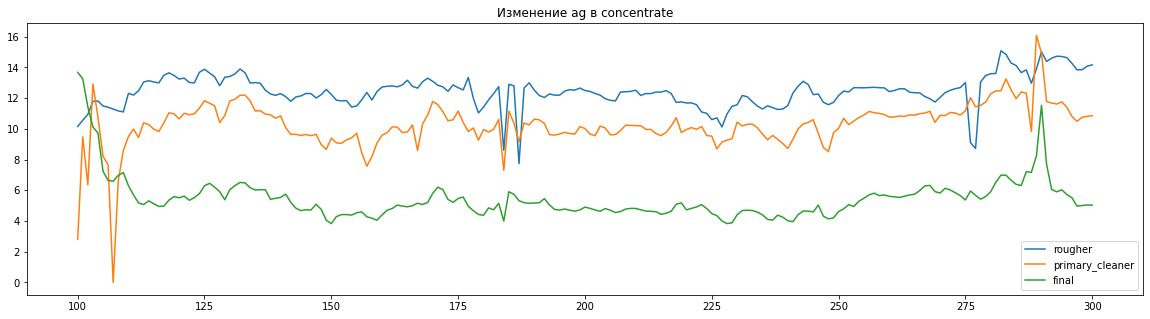

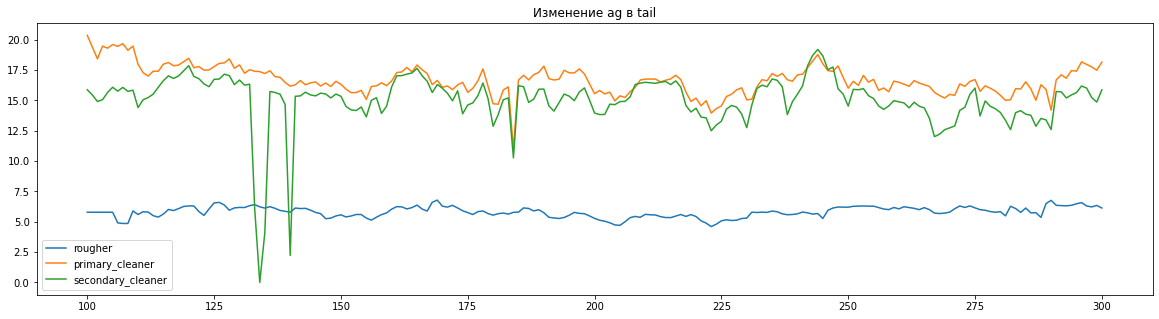

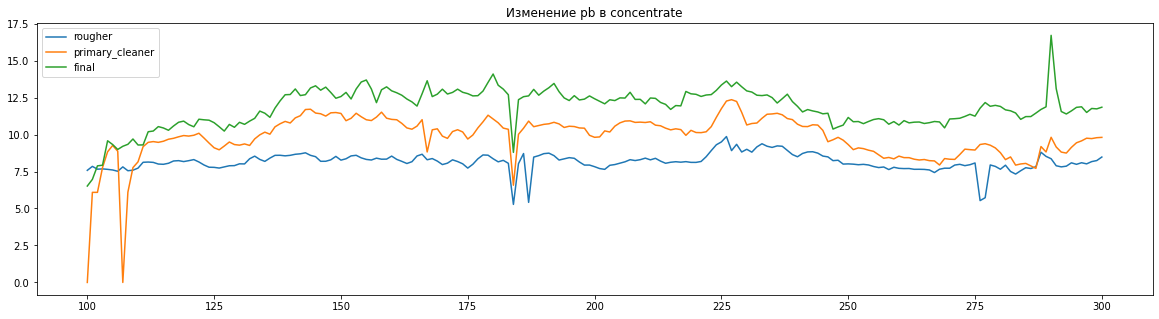

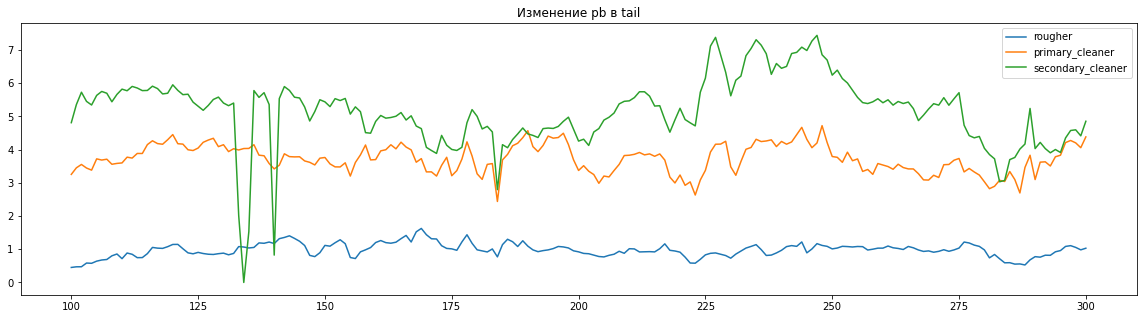

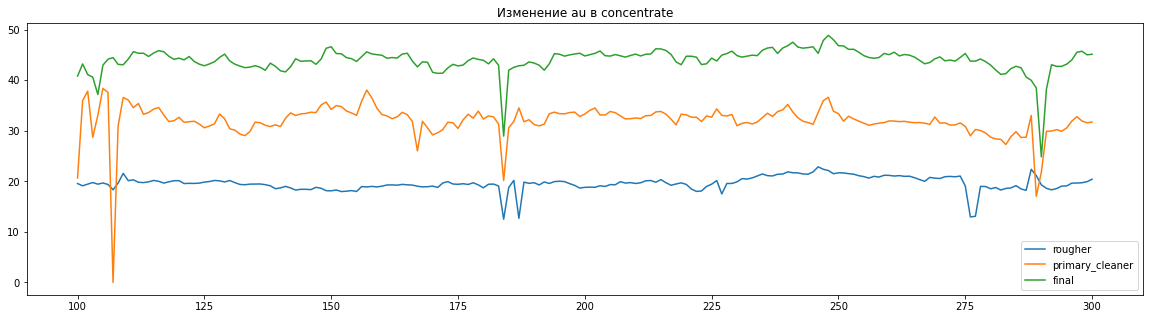

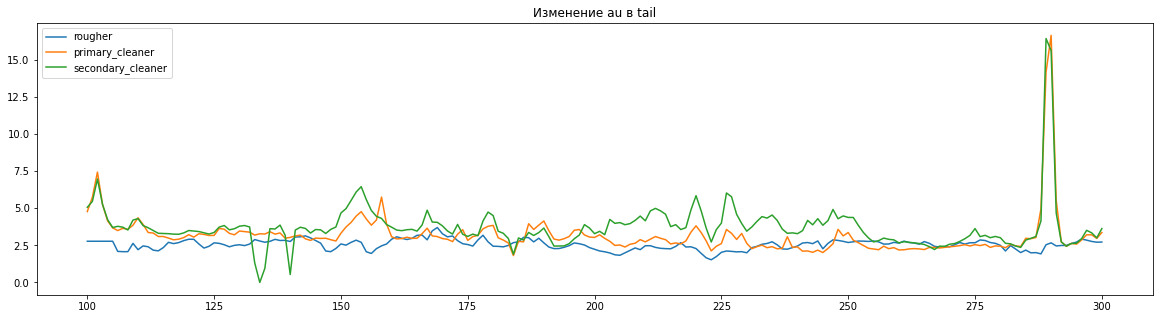

In [15]:
states = ['rougher', 'primary_cleaner', 'secondary_cleaner']
metals = ['ag', 'pb', 'au']
parts = ['concentrate', 'tail']

for metal in metals:
    for part in parts:
        plt.figure(figsize=(20,5))
        for i,state in enumerate(states):
            if i==2 and part=='concentrate':
                state='final'
            column_name=f'{state}.output.{part}_{metal}'
            data.loc[100:300,column_name].plot(label=state)
            plt.title(f'Изменение {metal} в {part}')
            plt.legend()
        plt.show()

<a name="2.2."></a>
## Сравниваем распределения размеров гранул сырья на обучающей и тестовой выборках
<font size="2">([к содержанию](#0.0))</font> 

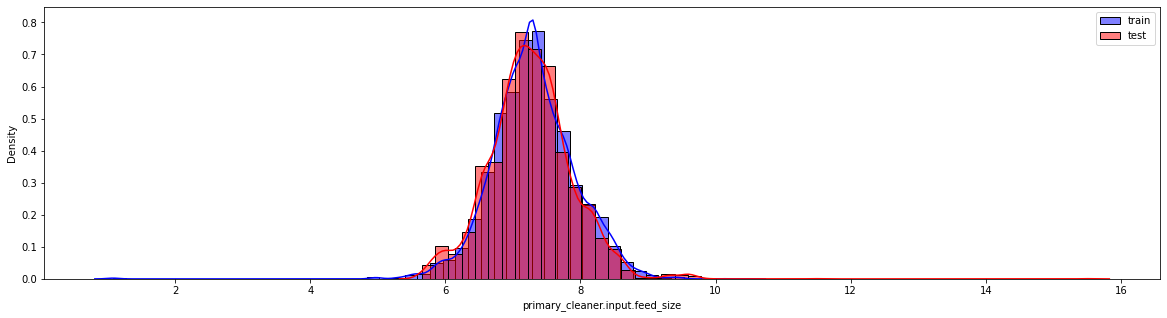

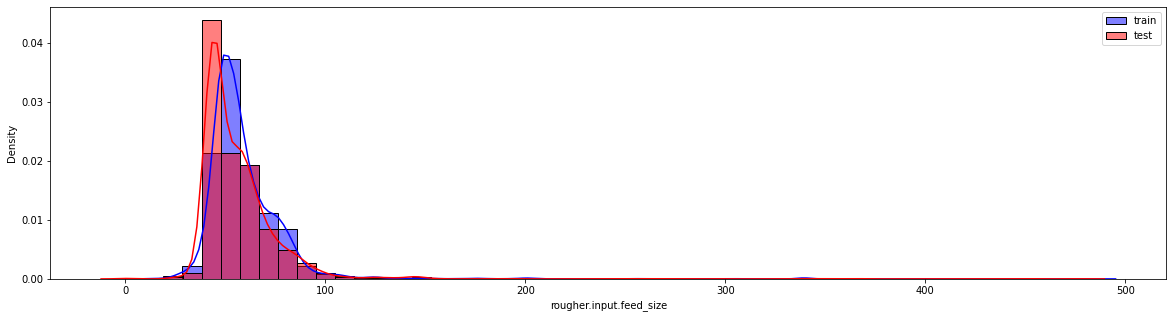

In [16]:
states = ['primary_cleaner.input.feed_size', 'rougher.input.feed_size']
dfs = [train_data, test_data]

for state in states:
    plt.figure(figsize=(20,5))
    sns.histplot(dfs[0][state], bins=50, label='train', fill=True,
                 stat='density', alpha=0.5, color='blue')
    sns.kdeplot(dfs[0][state], color='blue')
    sns.histplot(dfs[1][state], bins=50, label='test', fill=True,
                 stat='density', alpha=0.5, color='red')
    sns.kdeplot(dfs[1][state], color='red')
    plt.legend()
    plt.show()

<a name="2.3."></a>
## Исследуем суммарную концентрацию всех веществ на разных стадиях
<font size="2">([к содержанию](#0.0))</font> 

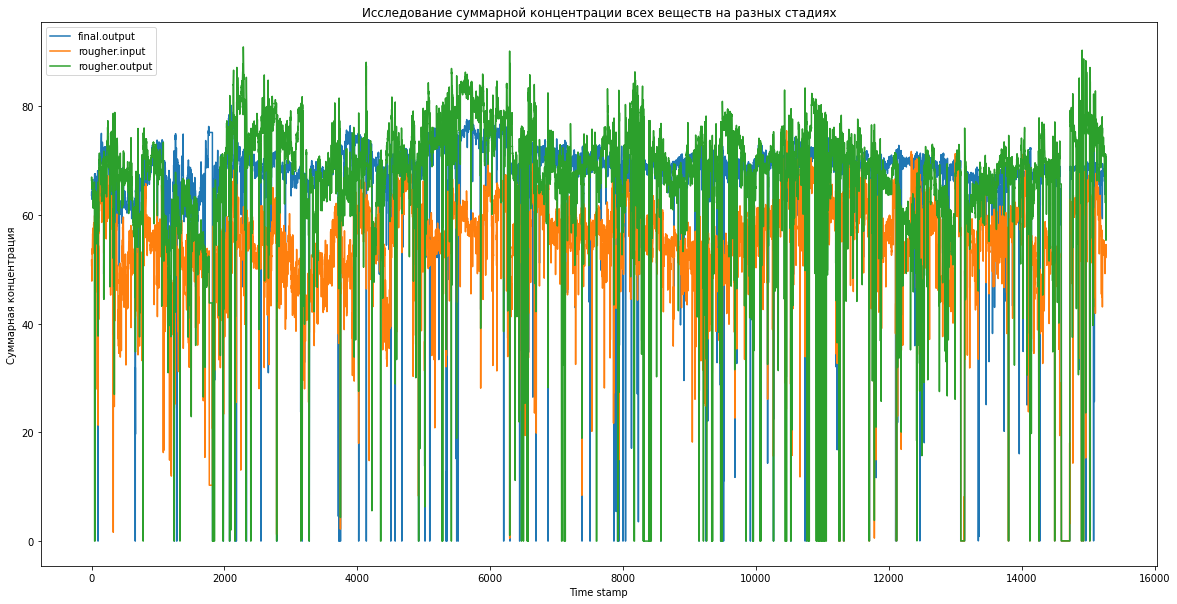

In [17]:
states = ['final.output', 'rougher.input', 'rougher.output']
params = ['concentrate_', 'feed_','concentrate_']
metals = ['ag','pb','au', 'sol']

df_for_parse = pd.DataFrame(columns=states)

for state in zip(states, params):
    sum_concentrate = train_data[f'{state[0]}.{state[1]}{metals[0]}'].copy()
    for metal in metals[1:]:
        sum_concentrate += train_data[f'{state[0]}.{state[1]}{metal}']
    df_for_parse[state[0]]=sum_concentrate

df_for_parse.plot(figsize=(20,10))
plt.legend()
plt.title('Исследование суммарной концентрации всех веществ на разных стадиях')
plt.ylabel('Суммарная концентрация')
plt.xlabel('Time stamp')
plt.show()

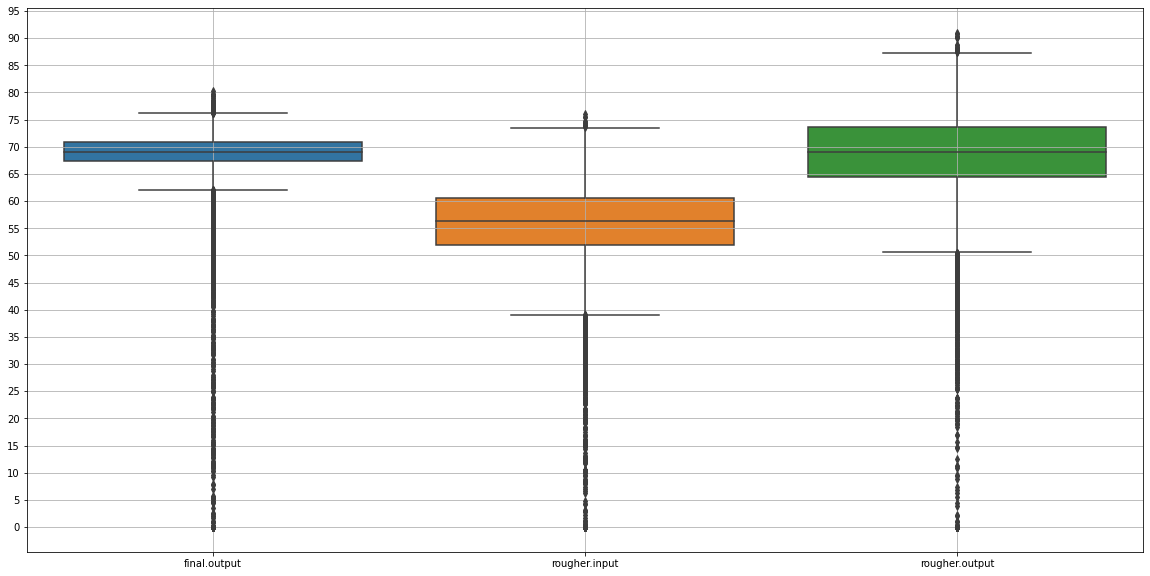

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df_for_parse, ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.grid()
plt.show()

In [19]:
# Вычислим суммарную концентрацию на rougher.input на обучающем
train_data['sum_concentrate'] = (train_data['rougher.input.feed_ag'] +
                                 train_data['rougher.input.feed_pb'] +
                                 train_data['rougher.input.feed_sol'] +
                                 train_data['rougher.input.feed_au'])

In [20]:
# Вычислим суммарную концентрацию на rougher.input на тестовом
test_data['sum_concentrate'] = (test_data['rougher.input.feed_ag'] +
                                test_data['rougher.input.feed_pb'] +
                                test_data['rougher.input.feed_sol'] +
                                test_data['rougher.input.feed_au'])

In [21]:
train_data.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_calculated,sum_concentrate
count,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,1.527200e+04,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.

In [22]:
upper_outler = train_data['sum_concentrate'].mean() + 3 * train_data['sum_concentrate'].std()
lower_outler = train_data['sum_concentrate'].mean() - 3 * train_data['sum_concentrate'].std()

In [23]:
# Отбрасываем все выбросы (выше и неже 3 сигма)
train_data = train_data[(train_data['sum_concentrate'] < upper_outler) & 
                        (train_data['sum_concentrate'] > lower_outler)]
test_data = test_data[(test_data['sum_concentrate'] < upper_outler) &
                      (test_data['sum_concentrate'] > lower_outler)]

In [24]:
# Также выбрасываем все значения с нулевыми значениями целевых признаков
train_data = train_data[(train_data['rougher.output.recovery'] > 0) &
                        (train_data['final.output.recovery'] > 0)]

In [25]:
data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)
train_data.set_index('date', inplace=True)

In [26]:
test_target = data.loc[test_data.index][['rougher.output.recovery',
                                         'final.output.recovery']]

In [27]:
# Найдите MAE между вашими расчётами и значением признака после устранения всех выбросов
mean_absolute_error(train_data['rougher.output.recovery'],
                    train_data['rougher.output.recovery_calculated'])

9.59928906192643e-15

<a name="2.4."></a>
## Вывод:

По мере продвижения пульпы по технологии доля серебра в концентрате планомерно уменьшается от одного этапа очистки к другому, а в хвостах наоборот, увеличивается, однако стоит отметить, что большая часть серебра уходит в хвосты на этапе флотации, а на этапах очистки концентрация серебра изменяется незначительно. Для свинца и золота ситуация противоположная: по мере обогащения и очистки сырья их доля в концентрате повышается. Стоит отметить, что концентрация золота в хвостах менается в меньшей степени, чем концентрация других металлов (и это логично, так как унос золота через хвосты стараются свести к минимуму).

Распределения размеров гранул сырья на обучающей и тестовой выборках имеют практический одинаковый вид что свидетельствует о том, что моделируемый процесс по времени является стационарным и данные для тестовых и обучающих выборок взяты из одной генеральной совокупности. Разница в высотах колокола обусловлена размерами выборок

При анализе концентраций веществ на различных стадиях были обнаружены аномалии, от которых мы избавляемся с помощью boxplot, на основании которых определяем граничные значения в диапазоне 3 сигма (99,7 % от всех данных). Выбрасываем мы только те значения, которые выходят за указанные диапазоны только в столбце rougher.input, так как остальные 2 столбца не являются входами модели машинного обучения и их отсев приведёт к потере значимой информации.

<font size="2">([к содержанию](#0.0))</font> 

<a name="3."></a>
# Шаг 3. Строим модель
<font size="2">([к содержанию](#0.0))</font> 

<a name="3.1."></a>
## Функция для вычисления sMAPE
<font size="2">([к содержанию](#0.0))</font> 

Эффективность обогащения рассчитывается по формуле:<br>
$sMAPE = \frac{1}{N}\sum \frac{|y_i-\widehat{y_i}|}{(|y_i|+|\widehat{y_i}|)/2}\times100%%$<br>

In [28]:
def sMAPE(actual, predicted):
    actual=np.array(actual)
    predicted=np.array(predicted)
    
    numerator=np.abs(actual-predicted)*2
    denominator=np.abs(actual)+np.abs(predicted)
    
    return (numerator/denominator).mean()*100

Итоговая метки:<br>
$sMAPE_{итоговая} = 0.25 \times sMAPE_{rougher} + 0.75 \times sMAPE_{final}$

In [29]:
def final_sMAPE(actual,predicted):
    actual=np.array(actual)
    predicted=np.array(predicted)
    return (0.25*sMAPE(actual[:,0], predicted[:,0])+
            0.75*sMAPE(actual[:,1], predicted[:,1]))

In [30]:
# Прогнозируемые значения из набора для обучения
train_target = train_data[['rougher.output.recovery',
                           'final.output.recovery']]

<a name="3.2."></a>
## Статическая модель с прогнозированием по медиане
<font size="2">([к содержанию](#0.0))</font> 

In [31]:
train_median = pd.DataFrame(index=train_target.index)
train_median['rougher.output.recovery'] = train_data['rougher.output.recovery'].median()
train_median['final.output.recovery'] = train_data['final.output.recovery'].median()
final_sMAPE(train_target, train_median)

9.732377506115977

<a name="3.3."></a>
## Статическая модель с прогнозированием по среднему
<font size="2">([к содержанию](#0.0))</font> 

In [32]:
train_mean = pd.DataFrame(index=train_target.index)
train_mean['rougher.output.recovery'] = train_data['rougher.output.recovery'].mean()
train_mean['final.output.recovery'] = train_data['final.output.recovery'].mean()
final_sMAPE(train_target, train_mean)

9.779334545964485

<a name="3.4."></a>
## Статическая модель с прогнозированием по предыдущим значениям
<font size="2">([к содержанию](#0.0))</font> 

In [33]:
#Один день - это 24 записи назад
train_actual = train_target[24:].reset_index(drop=True)
train_predicted = train_target[:-24].reset_index(drop=True)
final_sMAPE(train_actual, train_predicted)

10.635010657152439

<a name="3.5."></a>
## Обучение моделей с использованием кросс-валидации
<font size="2">([к содержанию](#0.0))</font> 

In [34]:
# Выделим features и targets
X = train_data[test_data.columns]
y = train_data[['rougher.output.recovery', 'final.output.recovery']]

In [35]:
# Отнормируем X
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [36]:
final_sMAPE_scorer = make_scorer(final_sMAPE, greater_is_better=False)

In [37]:
#Обучите разные модели и оцените их качество кросс-валидацией.
model = LinearRegression()
print('Линейная регрессия:', abs(cross_val_score(model, X, np.array(y),
                                                 cv=5, scoring=final_sMAPE_scorer)).mean())

Линейная регрессия: 10.329058183854661


In [38]:
%%time
param_grid = {'n_estimators' : [x for x in range(1, 200, 5)], 
              'max_depth' : [x for x in range(1, 9)]}

clf = GridSearchCV(estimator = RandomForestRegressor(random_state=0),
                   param_grid = param_grid,
                   scoring = final_sMAPE_scorer,
                   cv = 5, n_jobs = -1)
clf.fit(X,y)

Wall time: 1h 17min 55s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                          51, 56, 61, 66, 71, 76, 81, 86, 91,
                                          96, 101, 106, 111, 116, 121, 126, 131,
                                          136, 141, 146, ...]},
             scoring=make_scorer(final_sMAPE, greater_is_better=False))

In [39]:
print('Случайный лес', abs(clf.best_score_))

Случайный лес 8.986127244388175


In [40]:
%%time
param_grid_tree = {'max_depth' : [x for x in range(1,9)]}

clf_tree = GridSearchCV (estimator = DecisionTreeRegressor(random_state=12345), 
                    param_grid = param_grid_tree, 
                    scoring = final_sMAPE_scorer, 
                    cv = 5, n_jobs = -1)
clf_tree.fit(X,y)

Wall time: 2.59 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1, param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]},
             scoring=make_scorer(final_sMAPE, greater_is_better=False))

In [41]:
print('Решающее дерево', abs(clf_tree.best_score_))

Решающее дерево 9.348642578021215


In [42]:
# Выбираем лучшую модель и проверяем её на тестовой выборке
clf.best_params_

{'max_depth': 3, 'n_estimators': 26}

In [43]:
model = RandomForestRegressor(random_state=12345, max_depth=3, n_estimators=26)
model.fit(X,y)

RandomForestRegressor(max_depth=3, n_estimators=26, random_state=12345)

In [44]:
print('sMAPE на обучающей выборке:', final_sMAPE(y,model.predict(X)))

sMAPE на обучающей выборке: 7.731416379932417


In [45]:
print('sMAPE на тестовой выборке',final_sMAPE(test_target,
                                              model.predict(scaler.transform(test_data))))

sMAPE на тестовой выборке 9.250833703717714


<a name="4."></a>
# Шаг 4. Общие выводы

Cтатические модели можно получить разными методами: с помощью среднего или медианы из обучающей выборки или с помощью предыдущих значений на тестовых. Целесообразность последней статической модели обусловлена тем, что по сути данные у нас представляют собой временной ряд, значения которых не слишком сильно отличаются в соседних записях. Однако, чтобы не брать ближайшие значения, будем брать за день до фактического значения. На основании статического анализа следует полагать, что модель машинного обучения должна давать точность не менее 10.63% по sMAPE. При анализе результатов работы алгоритмов машинного обучения было выяснено, что наибольшую точность дают ансамбли деревьев. С помощью данной модели можно добиться 7.73% по sMAPE. На тестовых данных метрика получилась равной 9.25%, что всё равно ниже, чем при любых из исследованных статических моделях

<font size="2">([к содержанию](#0.0))</font> 